# Building Damage Assessment - Deep Neural Network

This notebook classify the building damage with simple neural network

## Set up and Load Data

### Google Drive & Path

In [ ]:
# from google.colab import drive # import drive from google colab
# ROOT = "/content/drive"     # default location for the drive
# print(ROOT)                 # print content of ROOT (Optional)

# drive.mount(ROOT)           # we mount the google drive at /content/drive

In [ ]:
# %cd "/content/drive/My Drive/FinalProj"
# %ls "./Data/FireDataset/train"

In [1]:
USER_NAME = "amun830"
OUTPUT_BUCKET = 'ml-satdata-aqeel' # (REMEMBER TO MOUNT THIS AGAIN, DOESN'T UPDATE LIVE WITH YOUR BUCKET)

In [2]:
import ee
from google.auth import compute_engine

scopes = ["https://www.googleapis.com/auth/earthengine"
]

credentials = compute_engine.Credentials(scopes=scopes)
ee.Initialize(credentials)

In [3]:
# Connect to google cloud
# CHANGE TO YOUR UPI
!gcloud config set account amun830

Updated property [core/account].


In [4]:
disaster_of_choice = "hurricane-michael"
location_coords = [30.1588, -85.6602]

In [5]:
!ls "Data/"

merged_test_hurricane-michael.cpg     merged_train_hurricane-michael-1.shp
merged_test_hurricane-michael.dbf     merged_train_hurricane-michael-1.shx
merged_test_hurricane-michael.prj     merged_train_hurricane-michael.cpg
merged_test_hurricane-michael.shp     merged_train_hurricane-michael.dbf
merged_test_hurricane-michael.shx     merged_train_hurricane-michael.prj
merged_train_hurricane-michael-1.cpg  merged_train_hurricane-michael.shp
merged_train_hurricane-michael-1.dbf  merged_train_hurricane-michael.shx
merged_train_hurricane-michael-1.prj


In [6]:
merged_path = "Data/"

### Prepare Packages

In [7]:
!pip install rasterio

In [8]:
!pip install geopandas

In [9]:
%pip install imagecodecs
!pip install tifffile
#need to upgrade to read compressed tiff in Colab
!pip install --upgrade scikit-image

Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install tensorflow

In [11]:
from skimage import io
import imagecodecs
import os, fnmatch,tifffile
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)
#check gpu
tf.config.list_physical_devices('GPU')



2023-09-24 09:00:41.702393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0


2023-09-24 09:00:43.275012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-24 09:00:43.283269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-24 09:00:43.283507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
# retrieve file path + names based on extension
def lstFiles(rootPath, ext):
    file_list = []
    root = rootPath
    for path, subdirs, files in os.walk(root):
        for names in files: 
            if names.endswith(ext) and not names.startswith("._"):
                file_list.append(path  +"/" + names)
    return(file_list)


# get merged all test/train dataset
merged_files = lstFiles(merged_path, '.shp')
gdf = gpd.read_file(merged_files[1])
santaRosa = gdf.query(f"location_n == '{disaster_of_choice}'")
ID_list=santaRosa.ID.unique()

In [ ]:
ID_list

In [15]:
#get files by match pattern
def find(pattern, path):
    '''
    #find names of files that match the pattern
    args:
    pattern: string to be matched
    path: path of files
    '''
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [17]:
folder=f'{OUTPUT_BUCKET}/NAIP_img_new/'
#the number of features
n_feature=44
data=np.empty(shape=(0,n_feature),dtype='float')
#counter=0
#combine all pre post images together
#for index in ID_list:
#test on a subset
for index in ID_list[:10]:
    #files=find('*'+index+'*.tif', folder) # data not returned in desired order for each index
    #pre
    img=io.imread(folder+'pre_'+index+'.tif')
    gt=io.imread(folder+'pre_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data=np.concatenate((data,img),axis=0)
    #post
    img=io.imread(folder+'post_'+index+'.tif')
    gt=io.imread(folder+'post_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data=np.concatenate((data,img),axis=0)
    #counter+=1
    #if counter%50==0:
        #print(index+'concatenated!')



## 5-layer Neural Network

In [18]:
#check device
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7972819650768959884
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7197425664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9912540265919442714
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
xla_global_id: 416903419
]


2023-09-24 09:02:11.599792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-24 09:02:11.600126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-24 09:02:11.600326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [19]:
# 
# try if reduce the size of non-building class would help
#import random
#Y=data[:,-1]
#ind_nonbuilding=np.where(Y==0)[0].tolist()
#ind_nonbuilding=random.sample(ind_nonbuilding, len(ind_nonbuilding)//7)
#ind_building=np.where(Y!=0)[0].tolist()
#ind_select=ind_nonbuilding+ind_building

In [20]:
#data_subset=data[ind_select]

In [22]:
#get ground truth label and group all types of damage as one type
Y=data[:,-1]
Y[Y>=2]=2
Y=Y.astype('int')

In [24]:
np.unique(Y)

array([0, 1, 2])

### Convert y variable to dummy variable

In [25]:
# encode class values as integers
# from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(Y, num_classes=3)

In [26]:
dummy_y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [27]:
#tf.debugging.set_log_device_placement(True)
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((data[:,:-1],dummy_y))
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(batch_size)

2023-09-24 09:02:42.814207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-24 09:02:42.814589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-24 09:02:42.814757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Define a 5-layer network for multi-class prediction

In [28]:
def model_settings(unit1,unit2,unit3,unit4,unit5):
    'define a 5-layer model and generate 3 categories: non-building, no-damage, destroyed'
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(unit1,activation="relu"),
        tf.keras.layers.Dense(unit2,activation='relu'),
        tf.keras.layers.Dense(unit3,activation='selu'),
        tf.keras.layers.Dense(unit4,activation='relu'),
        tf.keras.layers.Dense(unit5,activation='sigmoid'),
        #tf.keras.layers.Dense(3,activation='softmax')
        tf.keras.layers.Dense(3)
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#def model_settings(unit1,unit2):
#    'define a 2-layer model and generate 3 categories: non-building, no-damage, destroyed'
#    model = tf.keras.Sequential([
#        tf.keras.layers.Dense(unit1,activation="relu"),
#        tf.keras.layers.Dense(unit2,activation='sigmoid'),
#        tf.keras.layers.Dense(3)
#    ])
#    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model


In [29]:
#tune parameter with a batch to save time
tune_X,tune_y=next(iter(train_dataset))

In [30]:
unit1s=[1024,128,64,32,64,32,15]
unit2s=[512,64,32,16,32,16,10]
unit3s=[32,32,64,32,16,10,5]
unit4s=[10,16,32,32,10,5,3]
unit5s=[5,8,16,16,5,3,3]
#change epoch in here for tuning
num_epochs = 50


#for unit1 in unit1s:
#    for unit2 in unit2s:
for unit1, unit2, unit3, unit4,unit5 in zip(unit1s,unit2s,unit3s, unit4s,unit5s):
    model=model_settings(unit1,unit2,unit3,unit4,unit5)
    print('___')
    print('layer1: ',unit1,'; layer2: ',unit2,'; layer3: ',unit3,'; layer4: ',unit4,'; layer5: ',unit5)
    #use a validation split of 0.2 in here
    history = model.fit(tune_X, tune_y, epochs=num_epochs, validation_split = 0.2)

___
layer1:  1024 ; layer2:  512 ; layer3:  32 ; layer4:  10 ; layer5:  5
Epoch 1/50


2023-09-24 09:02:49.887941: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fde44012e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-24 09:02:49.887986: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P4, Compute Capability 6.1
2023-09-24 09:02:49.983709: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-24 09:02:50.428599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2023-09-24 09:02:50.799902: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - 5s 20ms/step - loss: 0.2993 - accuracy: 0.0000e+00 - val_loss: 0.2567 - val_accuracy: 0.0000e+00
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 0.2191 - accuracy: 0.0000e+00 - val_loss: 0.1751 - val_accuracy: 0.0000e+00
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1388 - accuracy: 0.0000e+00 - val_loss: 0.0934 - val_accuracy: 0.0000e+00
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0556 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0063 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 7/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0031 -

In [31]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 15)                660       
                                                                 
 dense_37 (Dense)            (None, 10)                160       
                                                                 
 dense_38 (Dense)            (None, 5)                 55        
                                                                 
 dense_39 (Dense)            (None, 3)                 18        
                                                                 
 dense_40 (Dense)            (None, 3)                 12        
                                                                 
 dense_41 (Dense)            (None, 3)                 12        
                                                                 
Total params: 917 (3.58 KB)
Trainable params: 917 (3.5

In [32]:
num_epochs = 201
#As show above, based on 20% validation, the best model is with 1024,512,32,10, 5 units for the five hidden layers
model_select=model_settings(1024,512,32,10,5)
#model_select=model_settings(15,3)

history = model_select.fit(train_dataset, epochs=num_epochs)

Epoch 1/201
573/573 [==============================] - 4s 3ms/step - loss: 0.7684 - accuracy: 0.1928
Epoch 2/201
573/573 [==============================] - 2s 3ms/step - loss: 0.2127 - accuracy: 0.0132
Epoch 3/201
573/573 [==============================] - 2s 3ms/step - loss: 0.2127 - accuracy: 0.0132
Epoch 4/201
573/573 [==============================] - 2s 3ms/step - loss: 0.2127 - accuracy: 0.0132
Epoch 5/201
573/573 [==============================] - 2s 3ms/step - loss: 0.2127 - accuracy: 0.0132
Epoch 6/201
573/573 [==============================] - 2s 3ms/step - loss: 0.2127 - accuracy: 0.0132
Epoch 7/201
573/573 [==============================] - 2s 3ms/step - loss: 0.2127 - accuracy: 0.0132
Epoch 8/201
573/573 [==============================] - 2s 3ms/step - loss: 0.2127 - accuracy: 0.0132
Epoch 9/201
573/573 [==============================] - 2s 3ms/step - loss: 0.2127 - accuracy: 0.0132
Epoch 10/201
573/573 [==============================] - 2s 3ms/step - loss: 0.2127 - accura

## Test Results

In [33]:
folder=f'{OUTPUT_BUCKET}/NAIP_img_new/'
#the number of features
n_feature=44
data_test=np.empty(shape=(0,n_feature),dtype='float')
shapes=[]
#counter=0
#combine all pre post images together
#for index in ID_list:
#test on a subset
for index in ID_list[10:15]:
    #files=find('*'+index+'*.tif', folder) # data not returned in desired order for each index
    #pre
    img=io.imread(folder+'pre_'+index+'.tif')
    gt=io.imread(folder+'pre_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    shapes.append(img.shape)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data_test=np.concatenate((data_test,img),axis=0)
    #post
    img=io.imread(folder+'post_'+index+'.tif')
    gt=io.imread(folder+'post_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    shapes.append(img.shape)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data_test=np.concatenate((data_test,img),axis=0)
    #if counter%50==0:
        #print(index+'concatenated!')



In [34]:
Y_test=data_test[:,-1]
Y_test[Y_test>=2]=2
Y_test=Y_test.astype('int')
dummy_y_test = to_categorical(Y_test, num_classes=3)

In [35]:
#tf.debugging.set_log_device_placement(True)
batch_size = 512
#get the test data
test_dataset = tf.data.Dataset.from_tensor_slices((data_test[:,:-1],dummy_y_test))
test_dataset = test_dataset.batch(batch_size)

In [36]:
#evaluate the model based on the test data
loss, accuracy = model_select.evaluate(test_dataset)

1032/1032 [==============================] - 3s 2ms/step - loss: 0.6069 - accuracy: 0.0377


In [37]:
#test
test_predictions=model_select.predict(test_dataset)

1032/1032 [==============================] - 1s 1ms/step


In [38]:
prediction_class= np.argmax(test_predictions, axis = 1)

In [39]:
print('The accuracy is: ',sum(prediction_class==Y_test)/len(Y_test))

The accuracy is:  0.03765611919039628


In [40]:
from sklearn import metrics

In [41]:
print('The accuracy and weighted f1 score for xgboost with best parameters are: ',metrics.accuracy_score(Y_test,prediction_class),' and ',metrics.f1_score(Y_test,prediction_class,average='weighted'))

The accuracy and weighted f1 score for xgboost with best parameters are:  0.03765611919039628  and  0.002733050547782004


In [42]:
print('The cohen Kappa is: ',metrics.cohen_kappa_score(Y_test,prediction_class),' and ',metrics.balanced_accuracy_score(Y_test,prediction_class))

The cohen Kappa is:  0.0  and  0.3333333333333333


In [43]:
cm=metrics.confusion_matrix(Y_test,prediction_class, labels=[0,1,2])
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[     0      0 441702]
 [     0      0  66379]
 [     0      0  19881]]


### Prediction and Visualization

In [44]:
def pred_visual(folder,index,state,features):
    '''
    This function takes one image, calculate the testing score on the image and visualize predictions
    folder: the folder (relative) to access the image
    index: string, image id: 00000XXX
    state: string, pre or post
    features: list of string, names of features
    '''
    img=io.imread(folder+state+'_'+index+'.tif')
    gt=io.imread(folder+state+'_'+index+'gt.tif')
    gt[gt>=2]=2
    shapes=img.shape
    #add ground truth as the last band
    img_data=np.concatenate((img,gt[:,:,None]),axis=2)
    img_data=np.reshape(img_data,(shapes[0]*shapes[1],(shapes[2]+1)))

    #organize dataframe
    img_data=pd.DataFrame(img_data,columns=features)
    X_te=img_data.iloc[:,:-1]
    y_te=img_data['y']
    #group y from 5 classes to 3 classes: 0: non building 1: undestroyed and 2: destroyed (remove minor and major imacts due to the limited samples)
    y_te[y_te>=2]=2
    y_te=y_te.astype('int')
    #pred_y=gbc.predict(X_te)
    test_predictions=model_select.predict(X_te)
    pred_y= np.argmax(test_predictions, axis = 1)
    print('The accuracy and Kappa for this image are: ',metrics.accuracy_score(y_te,pred_y),' and ',metrics.cohen_kappa_score(y_te,pred_y))
    pred_image=np.reshape(pred_y,(shapes[0],shapes[1]))

    #show images
    _, axs = plt.subplots(1, 3, figsize=(11, 12))
    axs = axs.flatten()
    #for img, ax in zip([np.uint8(img[:,:,:3]),gt,pred_image], axs):
    for img, ax in zip([img[:,:,:3]/255,gt,pred_image],axs):
        ax.grid(False)
        ax.imshow(img,vmin=0, vmax=2,cmap='brg')
    plt.show() 

In [45]:
features=['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'KMeans', 'KMeans_Seg', 'SNIC', 'LVQ']
features.append('y')

Pre fire prediction:
13/13 [==============================] - 0s 1ms/step
The accuracy and Kappa for this image are:  0.0  and  0.0


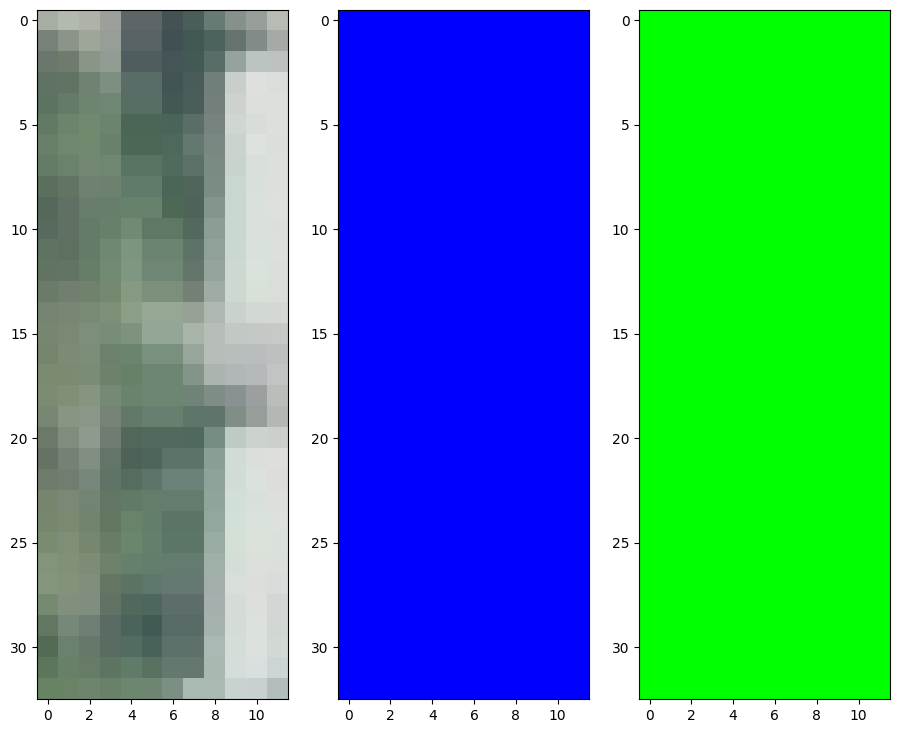

In [48]:
folder=f'{OUTPUT_BUCKET}/NAIP_img_new/'
index='00000005'
state='pre'
print('Pre fire prediction:')
pred_visual(folder,index,state,features=features)

Post fire prediction:
13/13 [==============================] - 0s 1ms/step
The accuracy and Kappa for this image are:  0.0  and  0.0


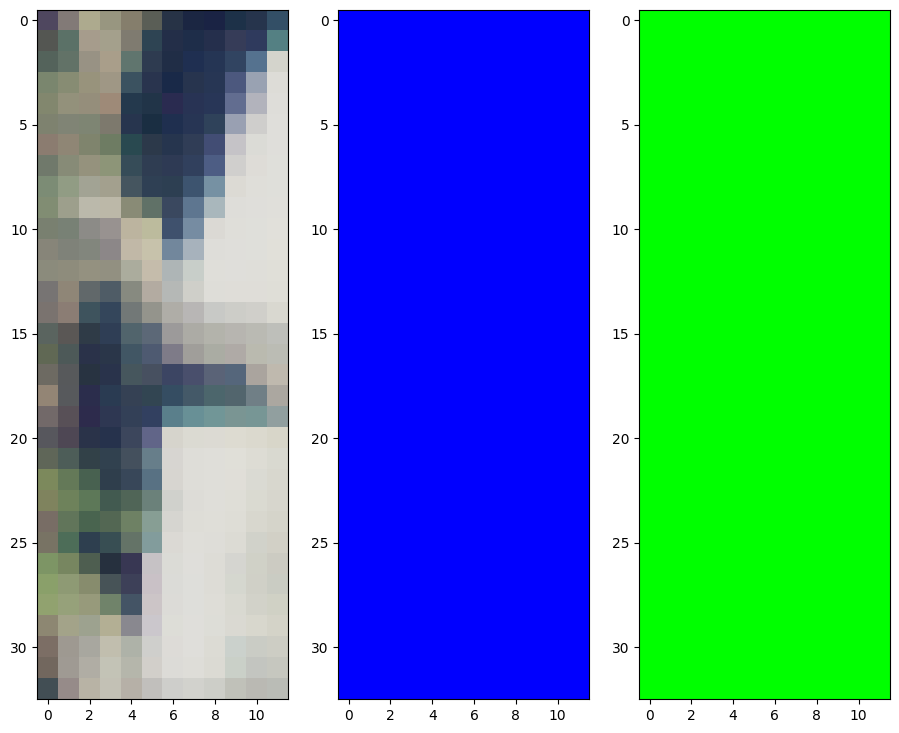

In [49]:
folder=f'{OUTPUT_BUCKET}/NAIP_img_new/'
index='00000005'
state='post'
print('Post fire prediction:')
pred_visual(folder,index,state,features=features)

__Results Interpretation__
The 5-layer deep neural networks doesn't seem to work well in both identifying building footprints and classifying damage type, especially when comparing with XGBoost (see XGBoost notebook). The high accuracy of 90.9% is only an actual ratio of sample distribution in the testing datasets (90% of the pixels in the testing set were non-building). The network will label all pixels as one type. Although the imbanlanced training sample size might be the problem, a follow-up model trained on the same training data with 6/7 of the non-building pixels randomly being dropped (so the ratio between non-building and building approximately equals to 1:1) also didn't show any improvement on this issue (however, all pixels were labeled as no-damage this time).

### Supplementary: Results from 2-layer neural network
Maps shown below are results from a 2-layer neural network. Although the accuracy is relatively lower (~0.8), the visualization of the results actually make more sense. There might be some error detection, but the 2-layer network is able to detect some pixels within the building boundary.

In [50]:
# show the first id image
index=ID_list[4]
img_pre=io.imread(folder+'pre_'+index+'.tif')
gt_pre=io.imread(folder+'pre_'+index+'gt.tif')
img_post=io.imread(folder+'post_'+index+'.tif')
gt_post=io.imread(folder+'post_'+index+'gt.tif')

In [51]:
#for pre and post of the first image id
pred_pre=prediction_class[:shapes[0][0]*shapes[0][1]]
pred_post=prediction_class[shapes[0][0]*shapes[0][1]:shapes[0][0]*shapes[0][1]+shapes[1][0]*shapes[1][1]]

In [52]:
pred_pre=np.reshape(pred_pre,(shapes[0][0],shapes[0][1]))
pred_post=np.reshape(pred_post,(shapes[1][0],shapes[1][1]))

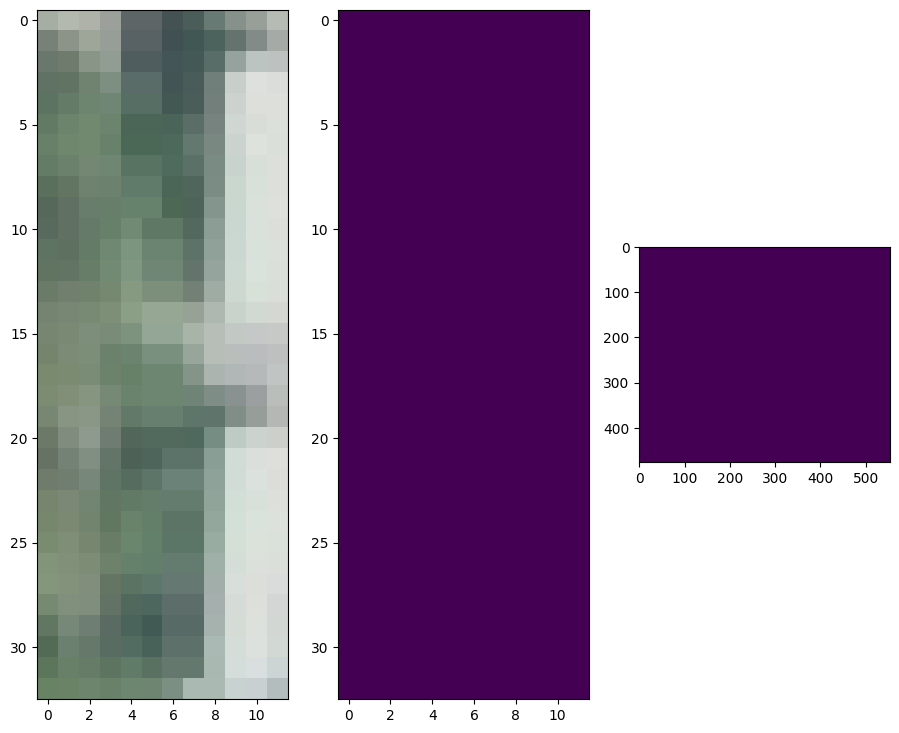

In [53]:
_, axs = plt.subplots(1, 3, figsize=(11, 12))
axs = axs.flatten()
for img, ax in zip([np.uint8(img_pre[:,:,:3]),gt_pre,pred_pre], axs):
    ax.imshow(img)
plt.show()

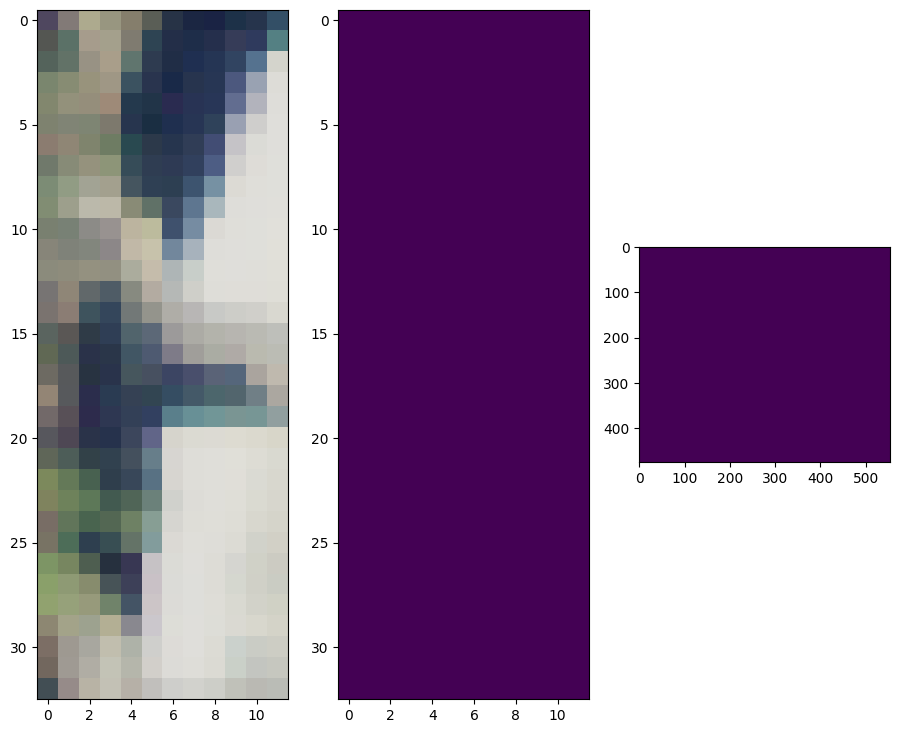

In [54]:
_, axs = plt.subplots(1, 3, figsize=(11, 12))
axs = axs.flatten()
for img, ax in zip([np.uint8(img_post[:,:,:3]),gt_post,pred_post], axs):
    ax.imshow(img)
plt.show()

In [59]:
# show the first id image
index=ID_list[2]
img_pre=io.imread(folder+'pre_'+index+'.tif')
gt_pre=io.imread(folder+'pre_'+index+'gt.tif')
img_post=io.imread(folder+'post_'+index+'.tif')
gt_post=io.imread(folder+'post_'+index+'gt.tif')

In [60]:
#for pre and post of the first image id
pred_pre=prediction_class[462966:462966+shapes[6][0]*shapes[6][1]]
pred_post=prediction_class[462966+shapes[6][0]*shapes[6][1]:462966+shapes[6][0]*shapes[6][1]+shapes[7][0]*shapes[7][1]]

IndexError: list index out of range

In [57]:
pred_pre=np.reshape(pred_pre,(shapes[6][0],shapes[6][1]))
pred_post=np.reshape(pred_post,(shapes[7][0],shapes[7][1]))

IndexError: list index out of range

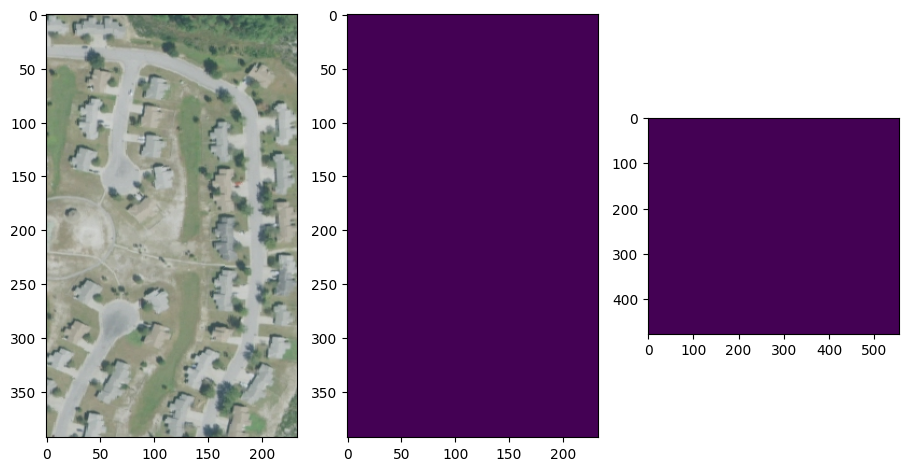

In [61]:
_, axs = plt.subplots(1, 3, figsize=(11, 12))
axs = axs.flatten()
for img, ax in zip([np.uint8(img_pre[:,:,:3]),gt_pre,pred_pre], axs):
    ax.imshow(img)
plt.show()

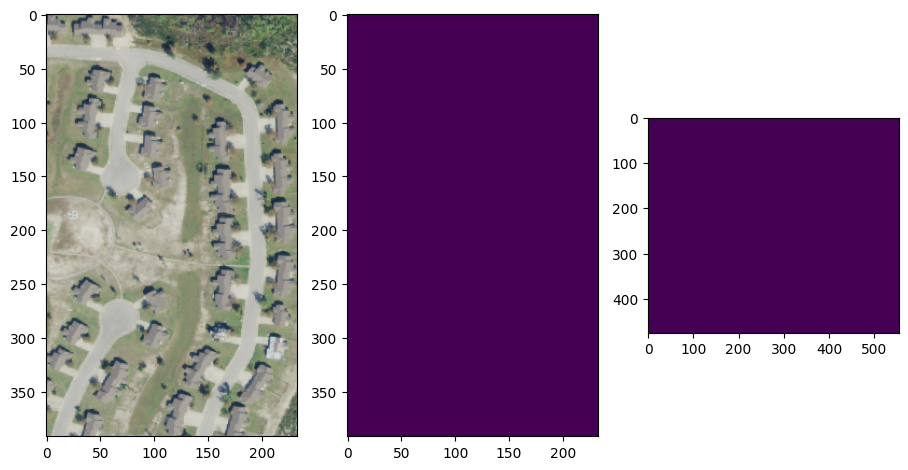

In [62]:
_, axs = plt.subplots(1, 3, figsize=(11, 12))
axs = axs.flatten()
for img, ax in zip([np.uint8(img_post[:,:,:3]),gt_post,pred_post], axs):
    ax.imshow(img)
plt.show()